# Dependence

In [1]:
import torch
import torch.nn as nn

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.tri as mtri

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameter

In [2]:
steps = 10
layers = np.array([2,32,32,1])
lr = 0.001

# Build mesh

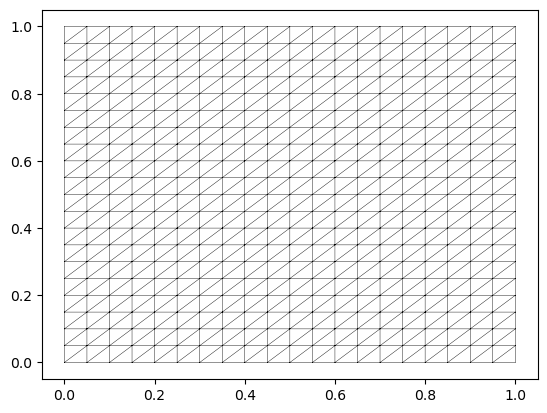

In [3]:
m_rows = 20
m_cols = 20

x = torch.linspace(0, 1, m_cols + 1)
y = torch.linspace(0, 1, m_rows + 1)
x = x.repeat(m_rows + 1)
y = y.repeat_interleave(m_cols + 1)
V = torch.stack([x,y],dim=1)
V_ref = V.clone()

tris = []

for i in range(m_cols):
   for j in range(m_rows):
       tris.append([j * (m_cols + 1) + i, j * (m_cols + 1) + i + 1, (j + 1) * (m_cols + 1) + i + 1])
       tris.append([j * (m_cols + 1) + i, (j + 1) * (m_cols + 1) + i + 1, (j + 1) * (m_cols + 1) + i])
        
tris = torch.tensor(tris)

plt.triplot(x,y,tris,'k-',linewidth=0.3)
plt.show()

# Moving Mesh Functions

In [ ]:
def Exact_U(V):
    #return torch.tanh(-30*(V[:,1]-0.5-0.25*torch.sin(2*torch.pi*V[:,0])))
    return torch.sin(2*torch.pi*V[:,0])*torch.cos(2*torch.pi*V[:,1])

def Metric(V):
    identity = [torch.eye(2) for _ in range(V.shape[0])]
    return torch.stack(identity, dim=0)
    

# Auxiliary Functions


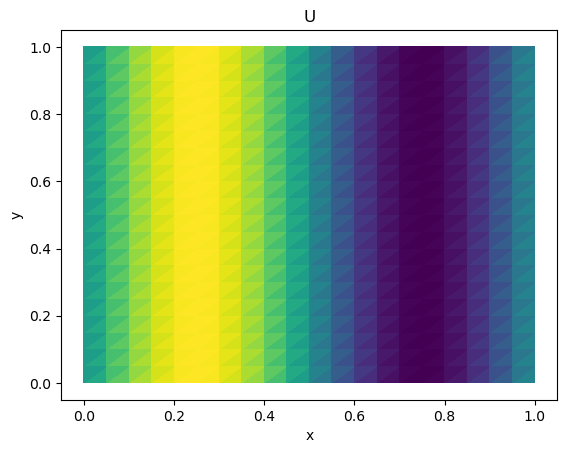

In [15]:
def Plot(V, U):
    _,ax=plt.subplots()
    ax.tripcolor(V[:,0],V[:,1],tris,U,cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('U')
    plt.show()
    
U = Exact_U(V)
Plot(V,U)

# Neural Network

In [200]:
class FCN(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.layers = layers 
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)   

    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(self.layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)    
        a = self.linears[-1](a)
        return a    
    
    def edge_matrix(self,V,tris):
        v1 = V[tris[:,0]]
        v2 = V[tris[:,1]]
        v3 = V[tris[:,2]]
        return torch.stack([v2-v1,v3-v1],dim=1)
    
    def jacobian(self,V_ref,V,tris):
        E_ref = self.edge_matrix(V_ref,tris)
        E = self.edge_matrix(V,tris)
        E_inv = torch.linalg.inv(E)
        return torch.bmm(E_ref, E_inv)
    
    def area(self,V,tris):
        E = self.edge_matrix(V,tris)
        return 0.5*torch.abs(E[:,0,0]*E[:,1,1]-E[:,0,1]*E[:,1,0])

    def loss(self,V_ref,V,tris):
        V.requires_grad = True
        V_ref.requires_grad = True
        J = self.jacobian(V_ref,V,tris)
        JT = J.transpose(1,2)
        vol = self.area(V,tris)
        JJT = torch.bmm(J,JT)
        traces = JJT[:,0,0] + JJT[:,1,1]
        return torch.dot(vol, traces)

# Train Neural Network

In [ ]:
V = V.float().to(device)
V_ref = V_ref.float().to(device)
tris = torch.tensor(tris,dtype=torch.long).to(device)

MMPDE_Net = FCN(layers)
MMPDE_Net.to(device)
params = list(MMPDE_Net.parameters())
optimizer = torch.optim.Adam(MMPDE_Net.parameters(),lr=lr,amsgrad=False)

for i in range(steps):
    loss = MMPDE_Net.loss(V_ref,V,tris)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



C:\Users\13162\AppData\Local\Temp\ipykernel_9104\385824614.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tris = torch.tensor(tris,dtype=torch.long).to(device)
